# build-cat-ccam_noresm2-mm_ssp126_aus-10i_12km

In [1]:
import glob
import pathlib
import traceback
from datetime import datetime

import xarray as xr

from ecgtools import Builder
from ecgtools.builder import INVALID_ASSET, TRACEBACK

from matplotlib import pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()
client

/g/data/v14/tm4888/miniconda3/envs/intake-stable-ecgtools/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37387 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37387/status,
Dashboard: /proxy/37387/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36691,Workers: 4
Dashboard: /proxy/37387/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:45651,Total threads: 1
Dashboard: /proxy/36831/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40997,


# build the catalogue

In [3]:
root = '/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/'

In [4]:
files = sorted(glob.glob(root+'*/*/*'))
len(files)

43761

In [5]:
files[0]

'/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/1hr/CAPE/CAPE_AUS-10i_NCC-NorESM2-MM_ssp126_r1i1p1f1_CSIRO-CCAM-2203_v1_1hr_20150101-20151231.nc'

In [6]:
ds = xr.open_mfdataset(files[0:11],parallel=True)
ds

<xarray.Dataset>
Dimensions:   (time: 96359, lat: 611, lon: 928, bnds: 2)
Coordinates:
  * lon       (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat       (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.4 8.5 8.6 8.7
  * time      (time) object 2015-01-01 01:00:00 ... 2025-12-31 23:00:00
Dimensions without coordinates: bnds
Data variables:
    CAPE      (time, lat, lon) float32 dask.array<chunksize=(8759, 611, 928), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float32 dask.array<chunksize=(8759, 611, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float32 dask.array<chunksize=(8759, 928, 2), meta=np.ndarray>
Attributes: (12/19)
    axiom_version:                  0.1.0
    axiom_schemas_version:          0.1.0
    axiom_schema:                   CORDEX
    contact:                        Marcus Thatcher (Marcus.Thatcher@csiro.au)
    Conventions:                    CF-1.7
    CORDEX_domain:                  AUS-10i
    ...                             ...
    model_id:                       CSIRO-CCAM-2203
    product:                        output
    project_id:                     CORDEX
    rcm_version_id:                 v1
    references:                     https://confluence.csiro.au/display/CCAM
    tracking_id:                    8e551fab-0fe9-425a-acdf-355ccbf92d64

In [7]:
path = pathlib.Path(files[0])
path.stem.split('_')

['CAPE',
 'AUS-10i',
 'NCC-NorESM2-MM',
 'ssp126',
 'r1i1p1f1',
 'CSIRO-CCAM-2203',
 'v1',
 '1hr',
 '20150101-20151231']

# NOTES from Marcus chat

## use this as an error check?

In [8]:
variable_list = [var for var in ds if 'long_name' in ds[var].attrs]
variable_list

['CAPE']

In [9]:
split = path.stem.split('_')

In [10]:
split[0]

'CAPE'

# do we really need to open all the files?  Given variable name is in the filename?

In [11]:
def parse_CCAM(file):
    """CCAM data stored in"""
    file = pathlib.Path(file)
    info = {}

    try:
        stem = file.stem
        split = stem.split('_')
        variable = split[0]
        domain = split[1]
        host_GCM = split[2]
        run_type = split[3]
        host_ensemble = split[4]
        downscale_model = split[5]
        downscale_version = split[6]
        period = split[7]
        if period == '1hr':
            time_period = 'hourly'
        elif period == '6hr':
            time_period = 'six_hourly'
        elif period == 'day':
            time_period = 'daily'
        elif period == 'mon':
            time_period = 'monthly'
        else:
            time_period = 'fixed'    

        
        info = {
            'variable': variable,
            'domain': domain,
            'host_GCM':host_GCM,
            'run_type':run_type,
            'host_ensemble':host_ensemble,
            'downscale_model':downscale_model,
            'downscale_version':downscale_version,
            'period': period,
            'time_period': time_period,
            'path': str(file),
        }
        return info
    
    except Exception:
        return {INVALID_ASSET: file, TRACEBACK: traceback.format_exc()}

In [12]:
parse_CCAM(files[0])

{'variable': 'CAPE',
 'domain': 'AUS-10i',
 'host_GCM': 'NCC-NorESM2-MM',
 'run_type': 'ssp126',
 'host_ensemble': 'r1i1p1f1',
 'downscale_model': 'CSIRO-CCAM-2203',
 'downscale_version': 'v1',
 'period': '1hr',
 'time_period': 'hourly',
 'path': '/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/1hr/CAPE/CAPE_AUS-10i_NCC-NorESM2-MM_ssp126_r1i1p1f1_CSIRO-CCAM-2203_v1_1hr_20150101-20151231.nc'}

# setup builder object

In [13]:
root2 = '/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1'

In [14]:
%%time
b = Builder([root2],depth=2)

CPU times: user 4.66 ms, sys: 0 ns, total: 4.66 ms
Wall time: 4.09 ms


In [15]:
b

Builder(paths=['/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1'], storage_options={}, depth=2, exclude_patterns=[], include_patterns=[], joblib_parallel_kwargs={})

In [16]:
%%time
b.build(parsing_func = parse_CCAM)

CPU times: user 6.94 s, sys: 4.11 s, total: 11.1 s
Wall time: 1min 9s


/g/data/v14/tm4888/miniconda3/envs/intake-stable-ecgtools/lib/python3.10/site-packages/ecgtools/builder.py:204: UserWarning: Unable to parse 4 assets. A list of these assets can be found in `.invalid_assets` attribute.
  ).clean_dataframe()


Builder(paths=['/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1'], storage_options={}, depth=2, exclude_patterns=[], include_patterns=[], joblib_parallel_kwargs={})

In [17]:
b.df

,variable,domain,host_GCM,run_type,host_ensemble,downscale_model,downscale_version,period,time_period,path
0,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
1,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
2,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
3,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
4,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
...,...,...,...,...,...,...,...,...,...,...
43756,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
43757,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
43758,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
43759,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...


In [18]:
dir(b)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get_validators__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init_post_parse__',
 '__pydantic_initialised__',
 '__pydantic_model__',
 '__pydantic_run_validation__',
 '__pydantic_validate_values__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__validate__',
 '__weakref__',
 '_root_dirs',
 'assets',
 'build',
 'clean_dataframe',
 'depth',
 'df',
 'entries',
 'exclude_patterns',
 'exclude_regex',
 'get_assets',
 'include_patterns',
 'include_regex',
 'invalid_assets',
 'joblib_parallel_kwargs',
 'parse',
 'paths',
 'save',
 'storage_options']

In [19]:
b.invalid_assets['INVALID_ASSET'].values

array([PosixPath('/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/fx/orog/orog_AUS-10i_NCC-NorESM2-MM_ssp126_r1i1p1f1_CSIRO-CCAM-2203_v1.nc'),
       PosixPath('/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/fx/sftlaf/sftlaf_AUS-10i_NCC-NorESM2-MM_ssp126_r1i1p1f1_CSIRO-CCAM-2203_v1.nc'),
       PosixPath('/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/fx/sftlf/sftlf_AUS-10i_NCC-NorESM2-MM_ssp126_r1i1p1f1_CSIRO-CCAM-2203_v1.nc'),
       PosixPath('/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/fx/sfturf/sfturf_AUS-10i_NCC-NorESM2-MM_ssp126_r1i1p1f1_CSIRO-CCAM-2203_v1.nc')],
      dtype=object)

## example from docs

In [22]:
!pwd

/home/599/tm4888


In [27]:
!cd /home/599/tm4888/intake-catalogues
!pwd

/home/599/tm4888


In [34]:
b.save(
    # File path - could save as .csv (uncompressed csv) or .csv.gz (compressed csv)
    name = "/intake-catalogues/ccam_noresm2-mm_ssp126_aus-10i_12km",
    # Column name including filepath
    path_column_name='path',
    # Column name including variables
    variable_column_name='variable',
    # Data file format - could be netcdf or zarr (in this case, netcdf)
    data_format="netcdf",
    # Which attributes to groupby when reading in variables using intake-esm
    groupby_attrs=["domain", "host_GCM", "run_type","host_ensemble","downscale_model","downscale_version","period"],
    # Aggregations which are fed into xarray when reading in data using intake
    aggregations=[
        {
            "type": "join_existing",
            "attribute_name": "date",
            "options": {"dim": "time", "coords": "minimal", "compat": "override"},
        }
    ],
)

Successfully wrote ESM catalog json file to: file:///home/599/tm4888//intake-catalogues/ccam_noresm2-mm_ssp126_aus-10i_12km.json


OSError: Cannot save file into a non-existent directory: '/jobfs/79614188.gadi-pbs/intake-catalogues'

# Can I querry the catalogue? YES!

In [30]:
import intake

### SICK OF ALL THESE WARNINGS?

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
data_catalog = intake.open_esm_datastore('/g/data/v14/tm4888/code/ACS/data-catalogue/catalogues/ccam_noresm2-mm_ssp126_aus-10i_12km.json')
data_catalog

,unique
variable,176
domain,1
host_GCM,1
run_type,1
host_ensemble,1
downscale_model,1
downscale_version,1
period,4
time_period,4
path,43757


In [36]:
data_catalog.df

,variable,domain,host_GCM,run_type,host_ensemble,downscale_model,downscale_version,period,time_period,path
0,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
1,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
2,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
3,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
4,CAPE,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
...,...,...,...,...,...,...,...,...,...,...
43752,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
43753,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
43754,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
43755,zmla,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...


In [37]:
data_catalog.df.variable.unique()

array(['CAPE', 'CIN', 'clh', 'clivi', 'cll', 'clm', 'clt', 'clwvi',
       'evspsbl', 'evspsblpot', 'hfls', 'hfss', 'hurs', 'huss', 'mrfsos',
       'mrsos', 'pr', 'prc', 'prsn', 'prw', 'ps', 'psl', 'rlds', 'rlus',
       'rlut', 'rsds', 'rsdsdir', 'rsdt', 'rsus', 'rsut', 'sfcWind',
       'tas', 'ts', 'ua100m', 'ua150m', 'ua200m', 'ua250m', 'ua300m',
       'ua50m', 'uas', 'va100m', 'va150m', 'va200m', 'va250m', 'va300m',
       'va50m', 'vas', 'zmla', 'hus10', 'hus100', 'hus1000', 'hus150',
       'hus20', 'hus200', 'hus250', 'hus30', 'hus300', 'hus400', 'hus50',
       'hus500', 'hus600', 'hus70', 'hus700', 'hus850', 'hus925', 'mrfso',
       'mrfsol', 'mrro', 'mrros', 'mrso', 'mrsol', 'snc', 'snd', 'snm',
       'snw', 'ta10', 'ta100', 'ta1000', 'ta150', 'ta20', 'ta200',
       'ta250', 'ta30', 'ta300', 'ta400', 'ta50', 'ta500', 'ta600',
       'ta70', 'ta700', 'ta850', 'ta925', 'tauu', 'tauv', 'tsl', 'ua10',
       'ua100', 'ua1000', 'ua150', 'ua20', 'ua200', 'ua250', 'ua30',
    

In [38]:
data_catalog.df.period.unique()

array(['1hr', '6hr', 'day', 'mon'], dtype=object)

In [39]:
search1 = data_catalog.search(variable=['tas'],period='mon')
search1

,unique
variable,1
domain,1
host_GCM,1
run_type,1
host_ensemble,1
downscale_model,1
downscale_version,1
period,1
time_period,1
path,85


In [40]:
search1.df

,variable,domain,host_GCM,run_type,host_ensemble,downscale_model,downscale_version,period,time_period,path
0,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
1,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
2,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
3,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
4,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
...,...,...,...,...,...,...,...,...,...,...
80,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
81,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
82,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...
83,tas,AUS-10i,NCC-NorESM2-MM,ssp126,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_ssp126_aus...


In [41]:
%%time
dsets = search1.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'domain.host_GCM.run_type.host_ensemble.downscale_model.downscale_version.period'


CPU times: user 1.82 s, sys: 251 ms, total: 2.07 s
Wall time: 11.9 s


In [42]:
dsets.keys()

dict_keys(['AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1f1.CSIRO-CCAM-2203.v1.mon'])

In [43]:
search_DS = dsets['AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1f1.CSIRO-CCAM-2203.v1.mon']

In [44]:
search_DS

<xarray.Dataset>
Dimensions:   (time: 1020, lat: 611, lon: 928, bnds: 2)
Coordinates:
  * time      (time) object 2015-01-15 12:00:00 ... 2099-12-15 12:00:00
    lat_bnds  (time, lat, bnds) float32 dask.array<chunksize=(12, 611, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float32 dask.array<chunksize=(12, 928, 2), meta=np.ndarray>
  * lon       (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat       (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.4 8.5 8.6 8.7
Dimensions without coordinates: bnds
Data variables:
    tas       (time, lat, lon) float32 dask.array<chunksize=(12, 611, 928), meta=np.ndarray>
Attributes: (12/29)
    axiom_version:                       0.1.0
    axiom_schemas_version:               0.1.0
    axiom_schema:                        CORDEX
    contact:                             Marcus Thatcher (Marcus.Thatcher@csi...
    Conventions:                         CF-1.7
    CORDEX_domain:                       AUS-10i
    ...                                  ...
    intake_esm_attrs:downscale_model:    CSIRO-CCAM-2203
    intake_esm_attrs:downscale_version:  v1
    intake_esm_attrs:period:             mon
    intake_esm_attrs:time_period:        monthly
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1...

In [46]:
mean_tas = search_DS.tas.mean(dim='time')
mean_tas

<xarray.DataArray 'tas' (lat: 611, lon: 928)>
dask.array<mean_agg-aggregate, shape=(611, 928), dtype=float32, chunksize=(611, 928), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat      (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.3 8.4 8.5 8.6 8.7

In [47]:
%%time
mean_tas = mean_tas.compute()

CPU times: user 1.37 s, sys: 244 ms, total: 1.61 s
Wall time: 11.1 s


In [48]:
mean_temp = mean_tas - 273.15

Text(0.5, 1.0, 'Mean Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

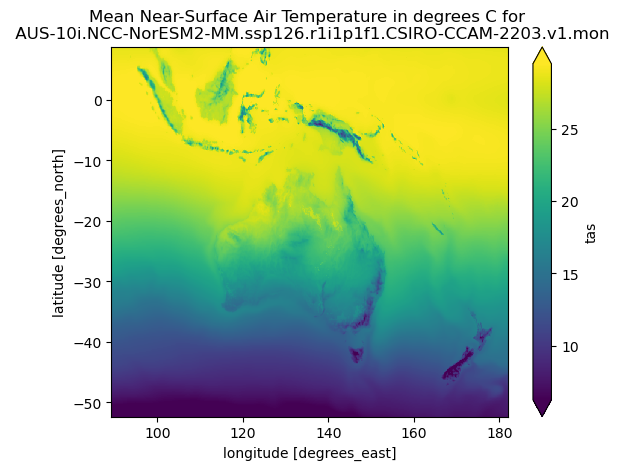

In [49]:
mean_temp.plot(robust=True)
plt.title('Mean Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

# seasonal climatology

In [50]:
tas_season_mean = search_DS.tas.groupby('time.season').mean('time')

In [51]:
tas_season_mean

<xarray.DataArray 'tas' (season: 4, lat: 611, lon: 928)>
dask.array<stack, shape=(4, 611, 928), dtype=float32, chunksize=(1, 611, 928), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat      (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.3 8.4 8.5 8.6 8.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   time: mean

In [52]:
temp_season_mean = tas_season_mean-273.15

In [53]:
temp_season_mean

<xarray.DataArray 'tas' (season: 4, lat: 611, lon: 928)>
dask.array<sub, shape=(4, 611, 928), dtype=float32, chunksize=(1, 611, 928), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat      (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.3 8.4 8.5 8.6 8.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

Text(0.5, 1.0, 'Winter(JJA) Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

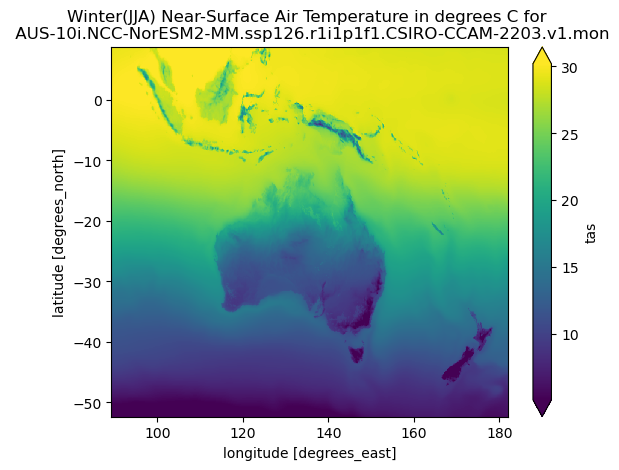

In [54]:
temp_season_mean.sel(season='JJA').plot(robust=True)
plt.title('Winter(JJA) Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

# compare to historical

In [30]:
client.close()